---
title: Spatial Temporal
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import metpy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [3]:
from pathlib import Path

In [4]:
Path("/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc").is_file()

True

In [5]:
# @dataclass
# class Subset:
#     _target_: str = "slice"
#     _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-10"])

In [6]:
from dataclasses import dataclass, field
from typing import List, Dict

@dataclass
class Subset:
    _target_: str = "builtins.slice"
    _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-10"])


# @dataclass
# class SSHDM:
#     _target_: str = "jejeqx._src.datamodules.natl60.SSHSTNATL60"
#     batch_size: int = 10_000
#     shuffle: bool = False
#     split_method: str = "random"
#     train_size: float = 0.80
#     spatial_coords: List = field(default_factory=lambda : ["x", "y", "z"])
#     temporal_coords: List = field(default_factory=lambda: ["time"])
#     variables: List = field(default_factory=lambda : ["ssh"])
#     coarsen: Dict = field(default_factory=lambda : {"lon": 4, "lat": 4})
#     directory: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/"
    
    
@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.coords.AlongTrackDM"
    batch_size: int = 10_000
    shuffle: bool = False
    train_size: float = 0.80
    subset_size: float = 0.30
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["sossheig"])
    coarsen: Dict = field(default_factory=lambda : {"lon": 4, "lat": 4})
    resample: str = "1D"
    # paths: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
    paths: str = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/test/dc_ref/NATL60-CJM165_GULFSTREAM*"
    

# # spatial transform
# transforms = Pipeline([
#     ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
#     ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
#     ("timedelta", TimeDelta("2012-10-01", 1, "s")),
#     ("timeminmax", MinMaxDF(["time"], -1, 1)),
# ])

# spatial transform
spatial_transforms = Pipeline([
    ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
    ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
])

temporal_transforms = Pipeline([
    ("timedelta", TimeDelta("2012-10-01", 1, "s")),
    ("timeminmax", MinMaxDF(["time"], -1, 1)),
])

In [7]:
select = {"time": slice("2012-10-22", "2012-11-02")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=spatial_transforms,
    temporal_transform=temporal_transforms,
)

In [8]:
xrda = dm.load_xrds()
xrda

<xarray.Dataset>
Dimensions:   (time: 12, lat: 150, lon: 150)
Coordinates:
  * lon       (lon) float64 -64.96 -64.89 -64.83 -64.76 ... -55.16 -55.09 -55.03
  * lat       (lat) float64 33.04 33.11 33.17 33.24 ... 42.77 42.84 42.91 42.97
  * time      (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-11-02
Data variables:
    sossheig  (time, lat, lon) float32 0.6505 0.659 0.6661 ... -0.1271 -0.1328
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

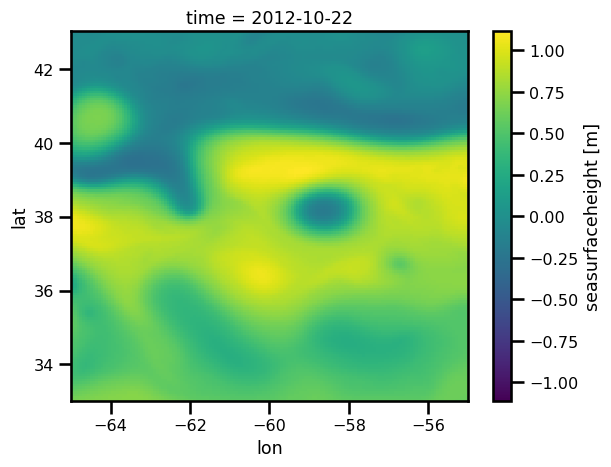

In [11]:
xrda.sossheig.isel(time=0).plot.pcolormesh(cmap="viridis")

In [12]:
# convert xarray to daraframe
ds = xrda.to_dataframe()

ds = ds.dropna()

# extract coordinates (for later)
coord_index = ds.index

# remove the indexing to get single columns
ds = ds.reset_index()

column_names = ds.columns.values

In [15]:
ds.describe()

,lat,lon,sossheig
count,270000.000000,270000.000000,270000.000000
mean,38.008333,-59.991667,0.414869
std,2.886693,2.886693,0.386058
min,33.041667,-64.958333,-0.442082
25%,35.508333,-62.491667,-0.006526
50%,38.008333,-59.991667,0.493637
75%,40.508333,-57.491667,0.737448
max,42.975000,-55.025000,1.118757


## Spatial Features


* Spherical
* Cartesian
* 



### Spherical Coordinates


$$
\begin{aligned}
R &\geq 0 \\
-180^\circ &\leq \theta \leq 180^\circ \\
-90^\circ &\leq \varphi \leq 90^\circ \\
\end{aligned}
$$

where:

* $\theta$ is the longitude
* $\varphi$ is the latitude
* $R$ is the radius of the Earth.


$$
\begin{aligned}
R &\geq 0 \\
-\pi &\leq \theta \leq \pi \\
-\frac{\pi}{2} &\leq \varphi \leq \frac{\pi}{2}  \\
\end{aligned}
$$

In [26]:
import math
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian

from jejeqx._src.transforms.dataframe.scaling import MinMaxDF, FixedScaler, Deg2Rad


spatial_transforms = Pipeline([
    ("deg2rad", Deg2Rad()),
    ("scaler", FixedScaler(
        [2/math.pi, 1/math.pi, ], 
        ["lat", "lon"])),
])

In [27]:
x = ds[["lat", "lon"]]

x = spatial_transforms.fit_transform(x)
x.describe()

,lat,lon
count,270000.000000,270000.000000
mean,0.422315,-0.333287
std,0.032074,0.016037
min,0.367130,-0.360880
25%,0.394537,-0.347176
50%,0.422315,-0.333287
75%,0.450093,-0.319398
max,0.477500,-0.305694


## Temporal Features


* Rescaling
* Cyclic Features

In [ ]:
from jejeqx._src.transforms.dataframe.temporal import TimeDelta